In [1]:
import numpy as np
from scipy import signal
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from data_module import DataModule
import pytorch_lightning as pl
from models import UNet, WeightedLoss
from pl_trainer import *
from utils import *
from pytorch_lightning.callbacks import ModelCheckpoint


In [18]:
class ValPloter(object):
    def __init__(self, a, h, path, draw_data=False):
        N = round(2*a/h)
        x = np.linspace(-a, a, N)
        y = np.linspace(-a, a, N)
        self.xx, self.yy = np.meshgrid(x, y)
        if not draw_data:
            self.us = list(Path(path).glob("Val_u*"))
            self.diffs = list(Path(path).glob("Val_diff*"))
        else:
            self.us = list(Path(path).glob("*.npy"))
    
    def draw(self, levels, n=10, diff=False):
        if diff:
            for d in self.diffs[:n]: 
                fig = plt.figure()
                fig.set_figheight(9)
                fig.set_figwidth(18)
                diff = np.load(d)
                z = 10 * (diff - diff.min())/(diff.max() - diff.min())
                ax1 = fig.add_subplot(1, 2, 1, projection='3d')
                ax2 = fig.add_subplot(1, 2, 2)
                surf = ax1.plot_surface(self.xx, self.yy, z,cmap=cm.coolwarm, linewidth=0, antialiased=False)
                cp = ax2.contour(self.xx, self.yy, z, colors='k', levels=levels)
                ax2.clabel(cp, inline=True, fontsize=10)
                fig.tight_layout()
        else:
            for u in self.us[:n]: 
                fig = plt.figure()
                fig.set_figheight(9)
                fig.set_figwidth(18)
                z = np.load(u)
                ax1 = fig.add_subplot(1, 2, 1, projection='3d')
                ax2 = fig.add_subplot(1, 2, 2)
                surf = ax1.plot_surface(self.xx, self.yy, z,cmap=cm.coolwarm, linewidth=0, antialiased=False)
                cp = ax2.contour(self.xx, self.yy, z, colors='k', levels=levels)
                ax2.clabel(cp, inline=True, fontsize=10)
                fig.tight_layout()
    
    def draw_data(self, levels, n=5):
        for u in self.us[:n]: 
                fig = plt.figure()
                fig.set_figheight(9)
                fig.set_figwidth(18)
                z = (np.load(u)[2,:,:]).squeeze()
                ax1 = fig.add_subplot(1, 2, 1, projection='3d')
                ax2 = fig.add_subplot(1, 2, 2)
                surf = ax1.plot_surface(self.xx, self.yy, z,cmap=cm.coolwarm, linewidth=0, antialiased=False)
                cp = ax2.contour(self.xx, self.yy, z, colors='k', levels=levels)
                ax2.clabel(cp, inline=True, fontsize=10)
                fig.tight_layout()

    def __len__(self):
        return len(self.us)

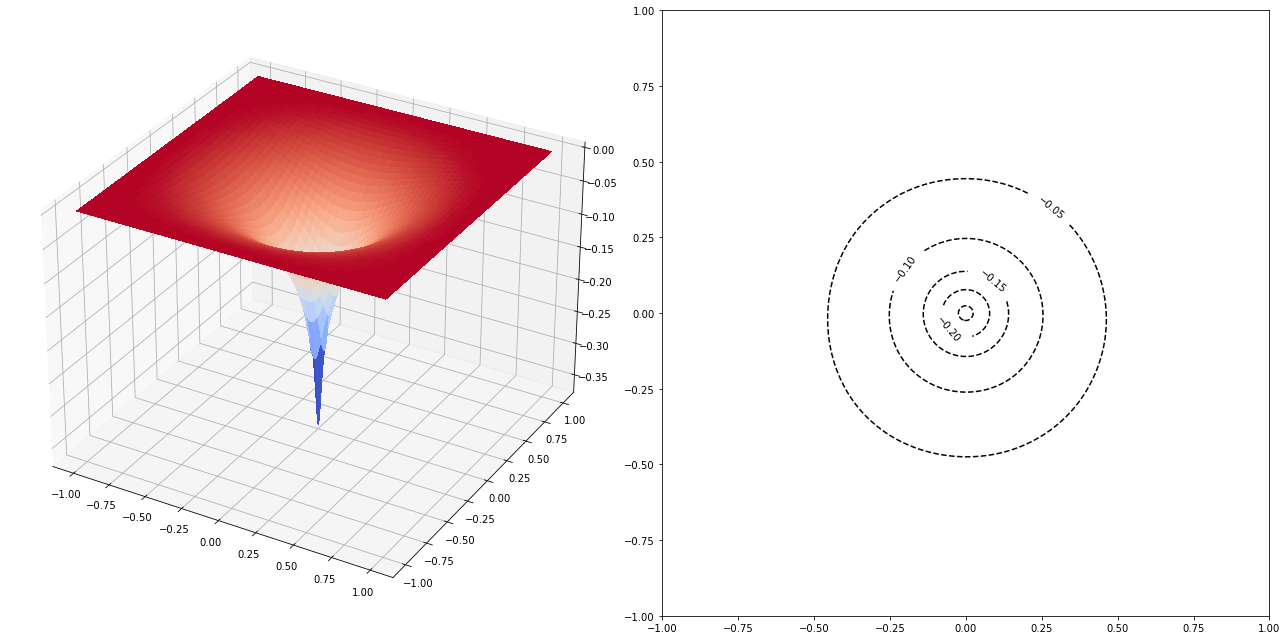

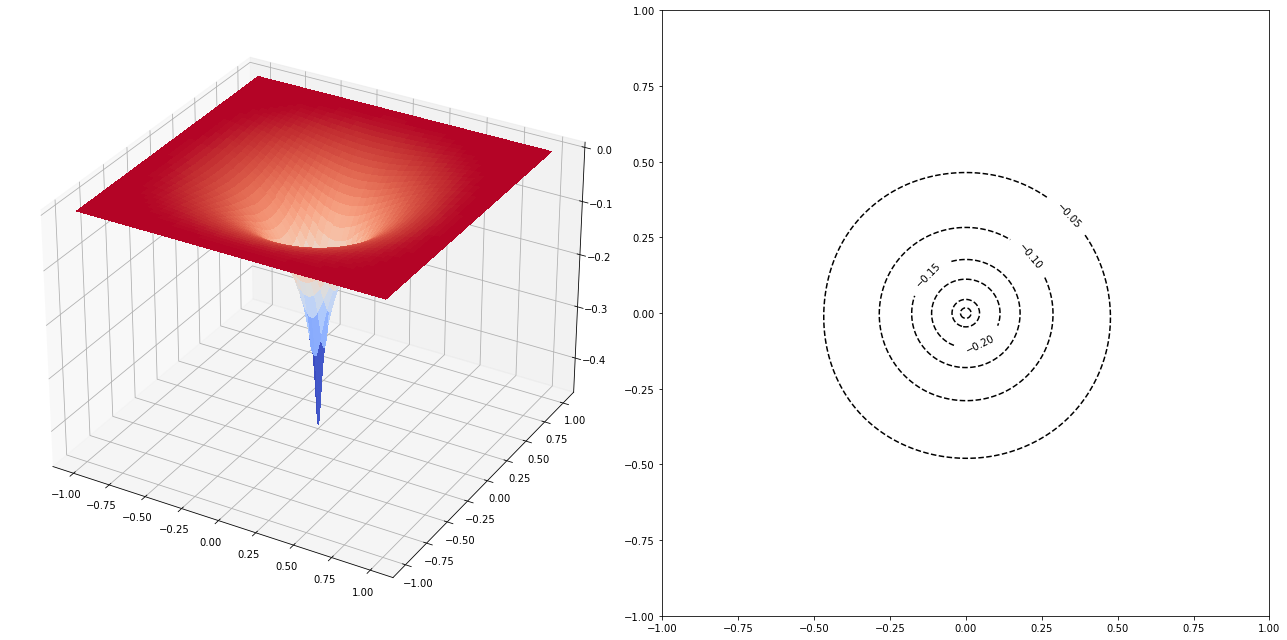

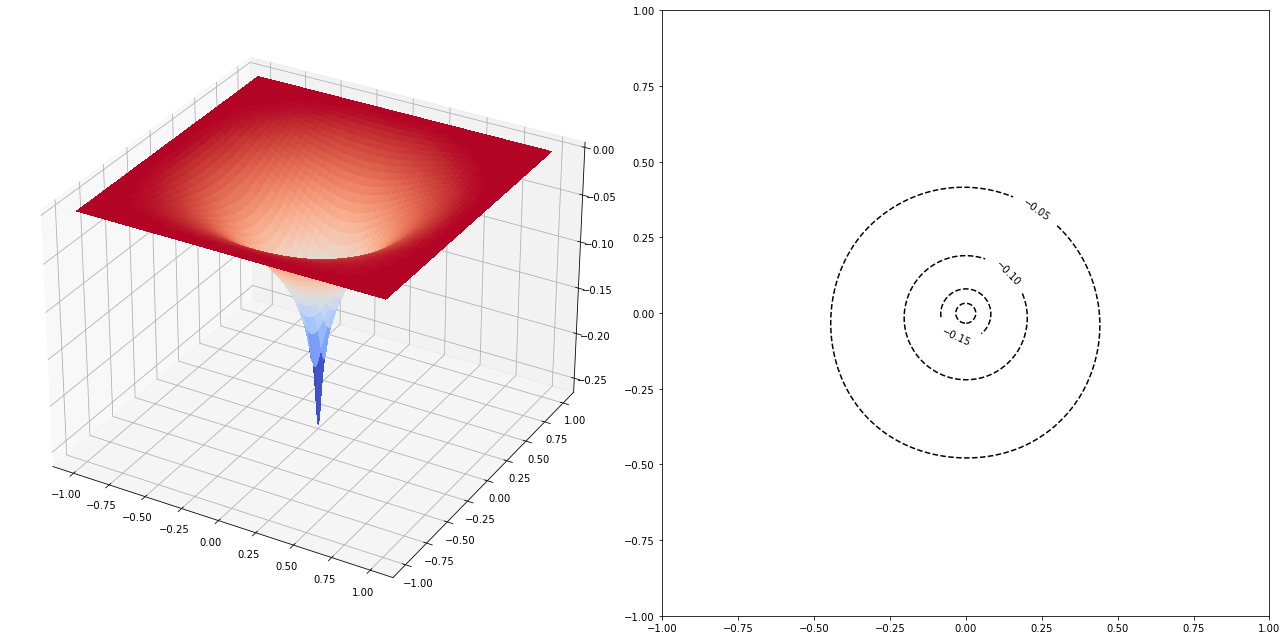

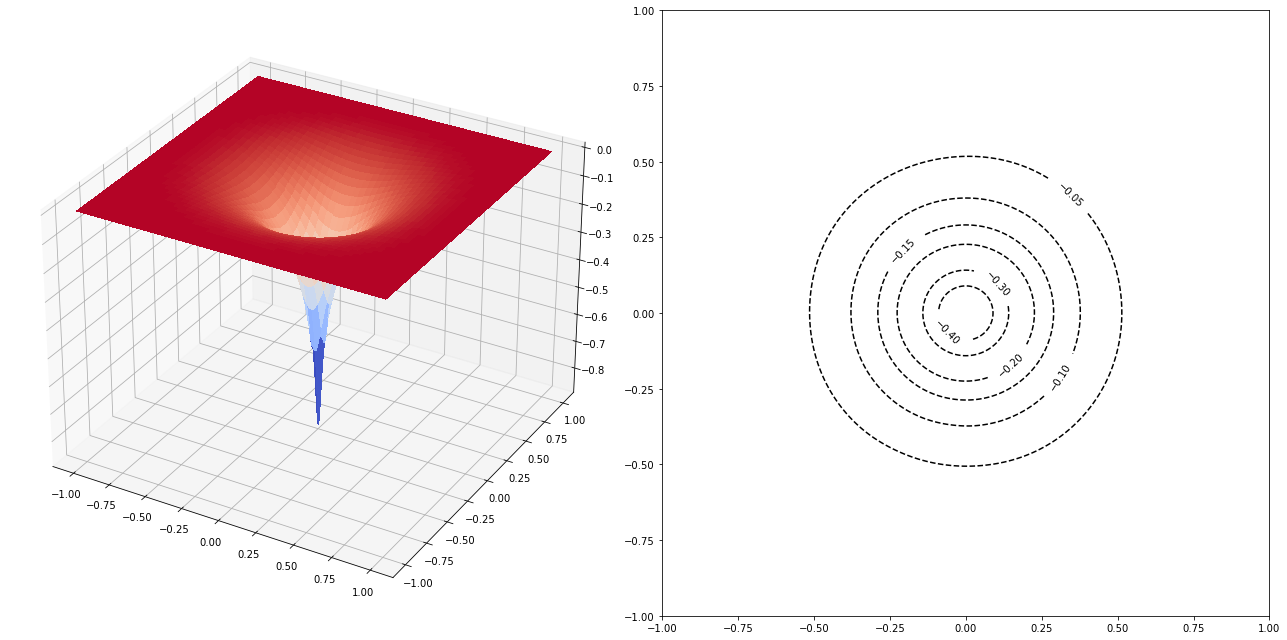

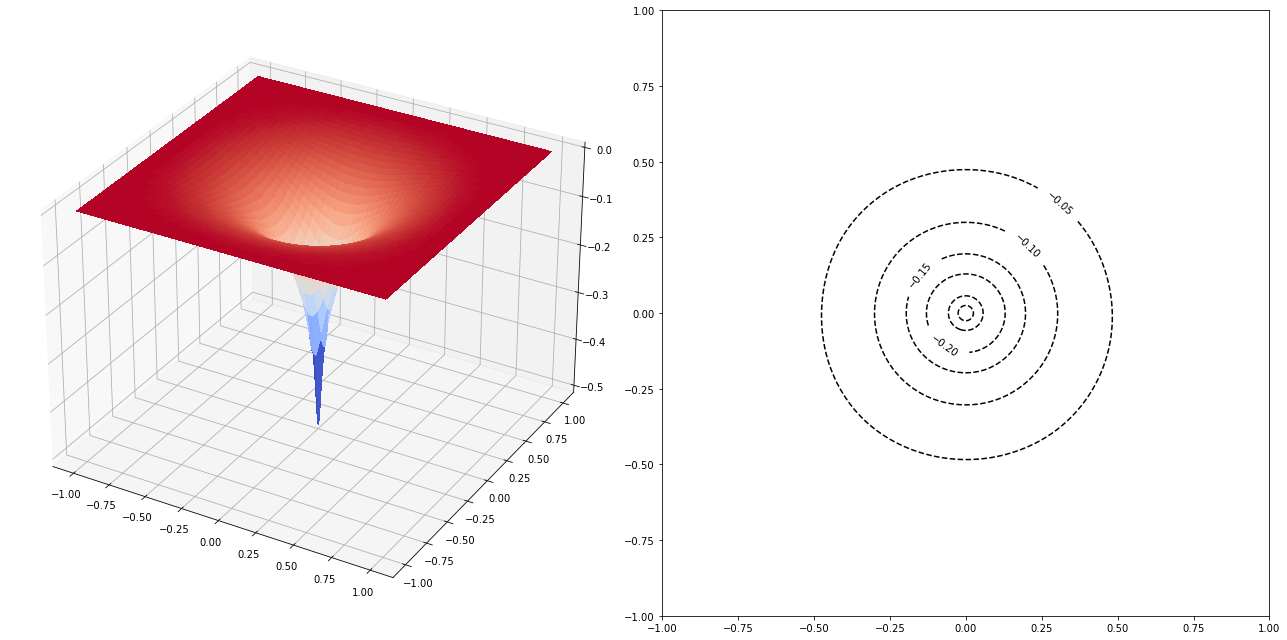

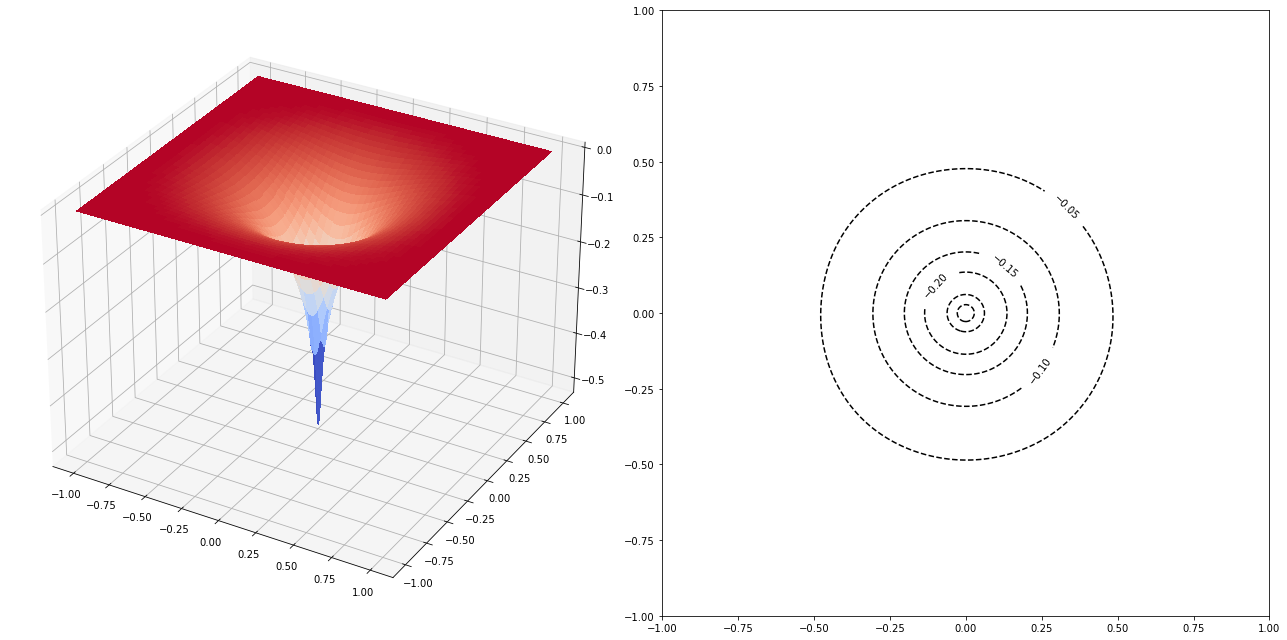

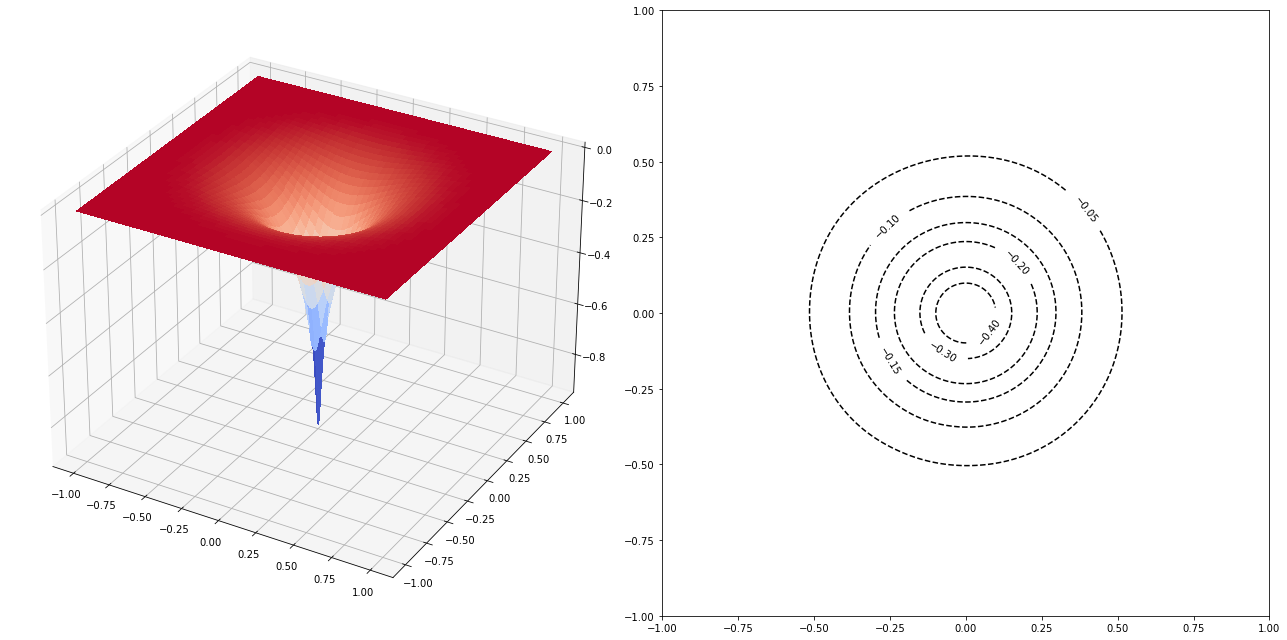

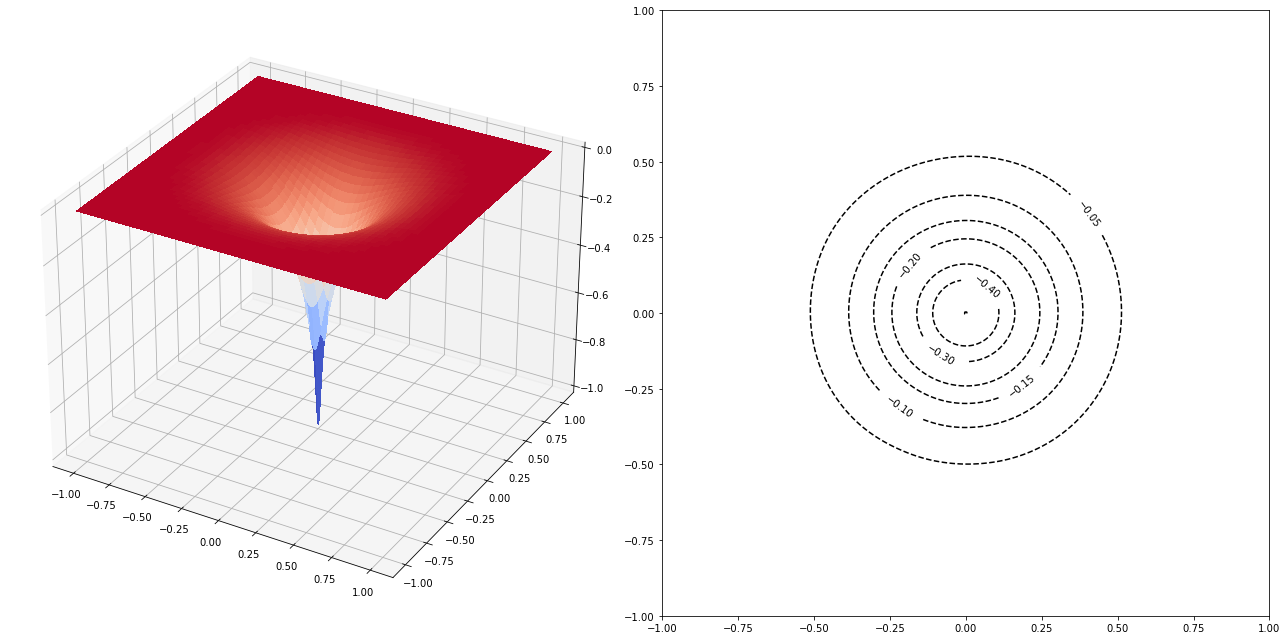

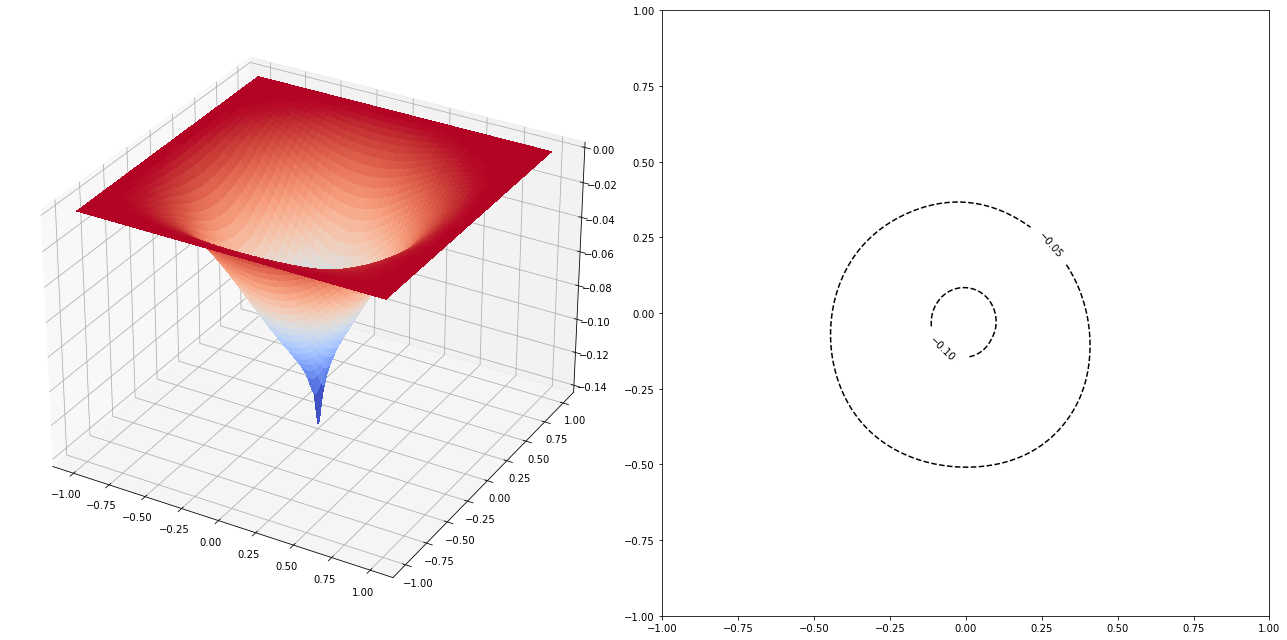

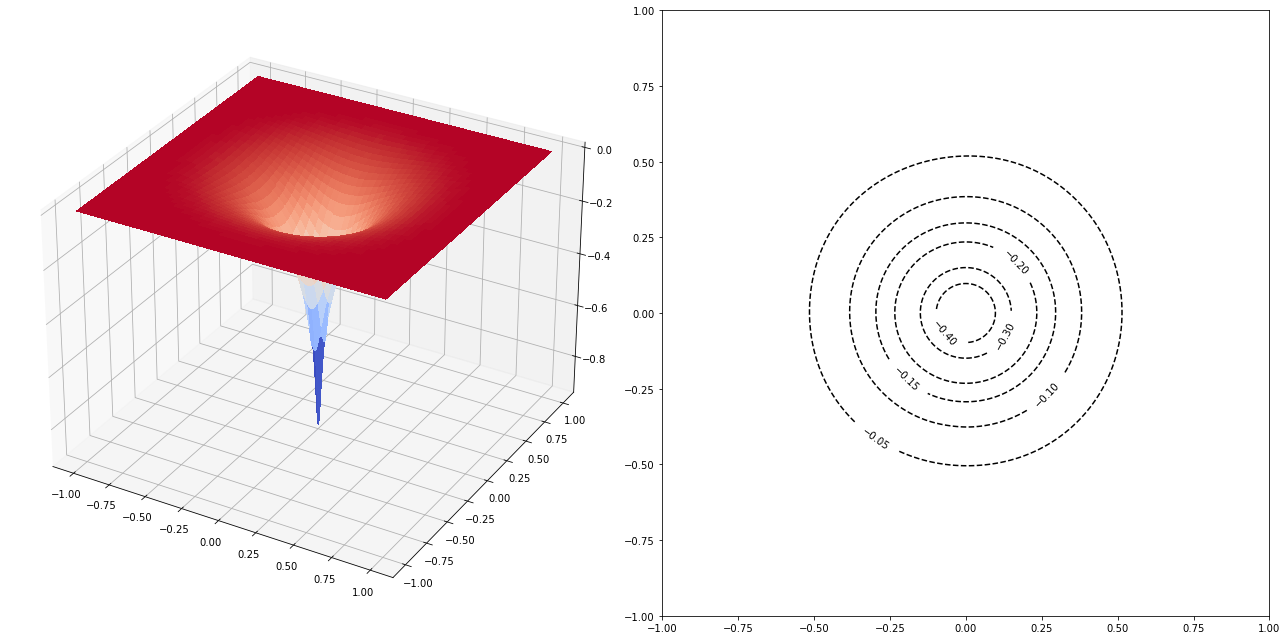

In [20]:
# val_plotter = ValPloter(500, 2.5, './u/case1/')
# val_plotter.draw(levels=[65, 75, 80, 85, 90, 95, 99])

val_plotter = ValPloter(1, 0.005, './u/case1/')
val_plotter.draw(levels=[-1.0, -0.4, -0.3, -0.2, -0.15, -0.1, -0.05])
# val_plotter.draw(levels=None, diff=True)


# data_plotter = Ploter(500, 2.5, './data/case1')
# data_plotter.draw(levels=None)

# data_plotter = ValPloter(1, 0.005, './data/green/', True)
# data_plotter.draw_data(levels=None)

In [24]:
class TestPloter(object):
    def __init__(self, real_path, a, h, k, mean, sigma, model, rhs, ckpt,dv, nv=None):
        self.reals = list(Path(real_path).glob('*.npy'))
        N = round(2*a/h)
        x = np.linspace(-a, a, N)
        y = np.linspace(-a, a, N)
        self.xx, self.yy = np.meshgrid(x, y)
        self.a = a
        self.h = h
        self.ckpt = ckpt
        self.mean = mean
        self.sigma = sigma
        if not nv is None:
            self.model = model(net=UNet(), loss=WeightedLoss(diff_fun = F.l1_loss),fig_save_path = './u/case1/',lr=1e-3,
                            rhs=rhs(k, h, dv, nv))
        else:
            self.model = model(net=UNet(), loss=WeightedLoss(diff_fun = F.l1_loss),fig_save_path = './u/case1/',lr=1e-3,
                            rhs=rhs(k, h, dv))
        
        
    def triple_plot(self, levels):
        for r in self.reals:
            cap = -float(r.name[:-4])
            ans = np.load(r)
            pre = test_g(cap = cap, a=self.a, h=self.h, ckpt_path=self.ckpt,
                        mean=self.mean, sigma=self.sigma,model=self.model).numpy()
            fig = plt.figure()
            fig.set_figheight(9)
            fig.set_figwidth(29)
            plt.rcParams['font.size'] = '15'

            ax1 = fig.add_subplot(1, 3, 1, projection='3d')
            surf1 = ax1.plot_surface(self.xx, self.yy, ans, cmap=cm.Spectral, linewidth=0, antialiased=False)
            ax1.set_title(f'$REAL:Q={cap:.2f}$')

            ax2 = fig.add_subplot(1, 3, 2, projection='3d')
            surf1 = ax2.plot_surface(self.xx, self.yy, pre, cmap=cm.Spectral, linewidth=0, antialiased=False)
            ax2.set_title(f'$PRE:Q={cap:.2f}$')

            ax3 = fig.add_subplot(1, 3, 3)

            cp1 = ax3.contour(self.xx, self.yy, pre, colors='r', levels=levels, linewidths=2)
            cp2 = ax3.contour(self.xx, self.yy, ans, colors='b', levels=levels, linewidths=3, linestyles='solid')
            ax3.clabel(cp1, fmt='%.2f', inline=1, fontsize='large')
            ax3.clabel(cp2, fmt='%.2f', inline=1, fontsize='large')
            
    def fourth_plot(self, levels):
        pres = []
        reals = []
        caps = []
        
        for r in self.reals:
            cap = -float(r.name[:-4])
            caps.append(cap)
            reals.append(np.load(r))
            pres.append(test_g(cap = cap, a=self.a, h=self.h, ckpt_path=self.ckpt, mean=self.mean, sigma=self.sigma,
                              model=self.model).numpy())
        
        fig1 = plt.figure()
        fig1.set_figheight(20)
        fig1.set_figwidth(20)
        
        for i in range(4):
            ax = fig1.add_subplot(2,2, i+1, projection='3d')
            surf = ax.plot_surface(self.xx, self.yy, pres[i],cmap=cm.Spectral,linewidth=0, antialiased=False)
            ax.set_title(f'$Q=-{caps[i]:.2f}$',fontsize=25)
            fig1.colorbar(surf, ax=ax, shrink=0.5)
        
        fig2 = plt.figure()
        fig2.set_figheight(20)
        fig2.set_figwidth(20)
        
        for i in range(4):
            ax = fig2.add_subplot(2,2,i+1)
            ax.set_title(f'$Q=-{caps[i]:.2f}$',fontsize=25)
            cp1 = ax.contour(self.xx, self.yy, pres[i], colors='r', levels=levels, linewidths=2)
            cp2 = ax.contour(self.xx, self.yy, reals[i], colors='b', levels=levels, linewidths=3, linestyles='solid')
            ax.clabel(cp1, fmt='%.2f', inline=1, fontsize='large')
            ax.clabel(cp2, fmt='%.2f', inline=1, fontsize='large')


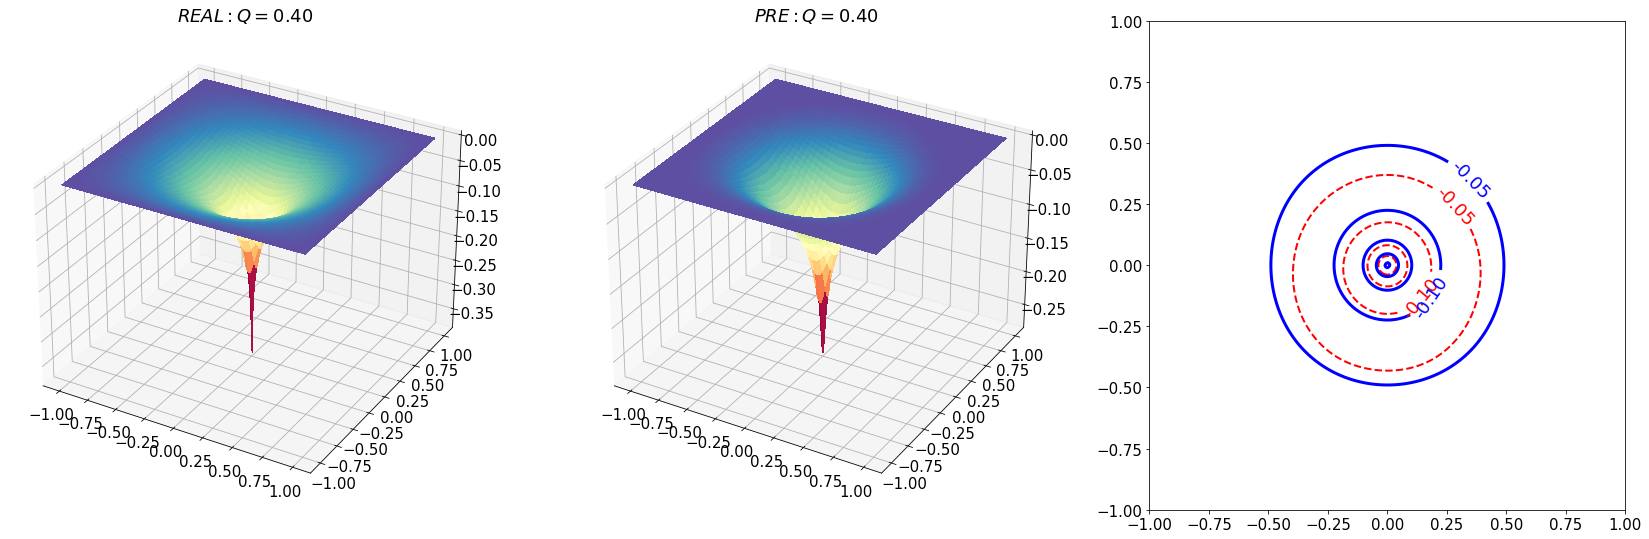

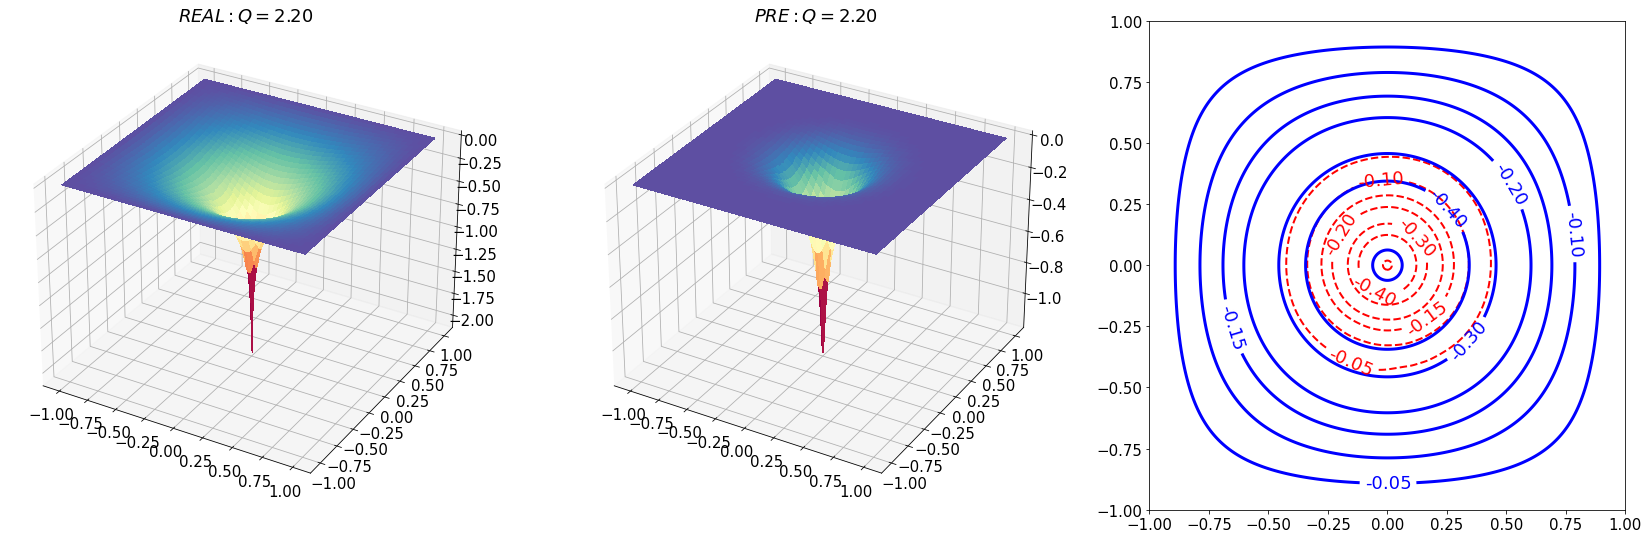

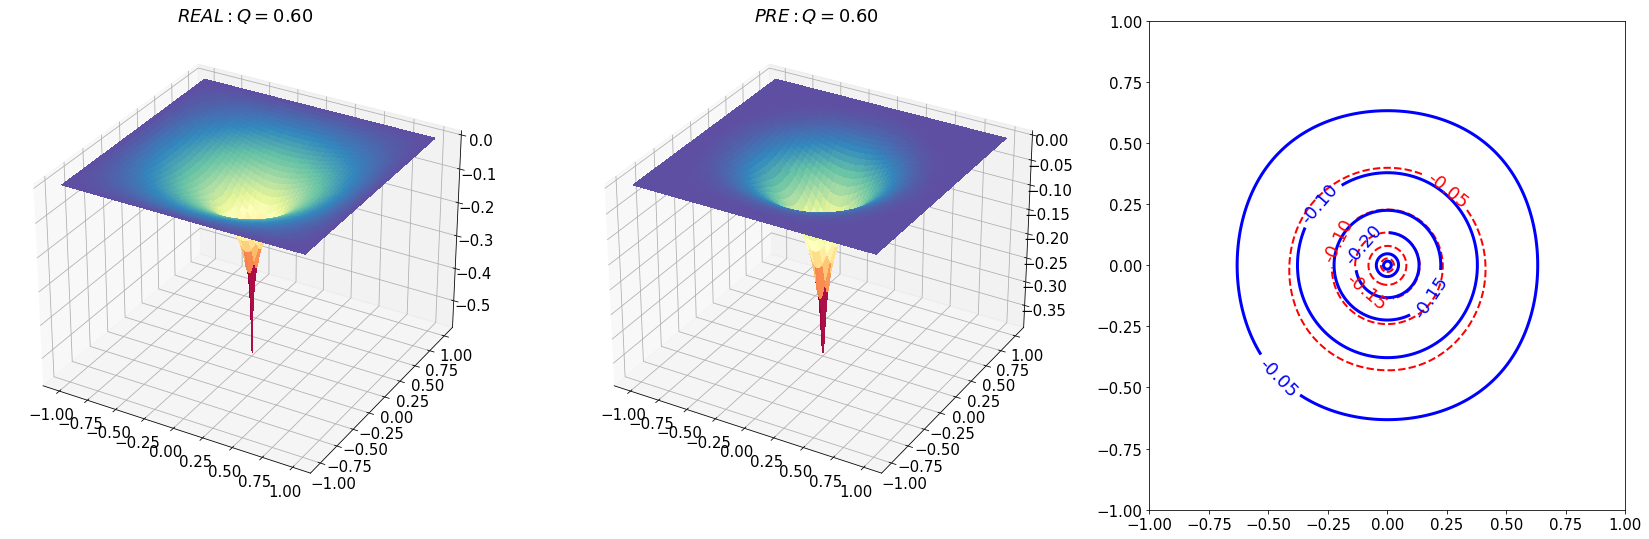

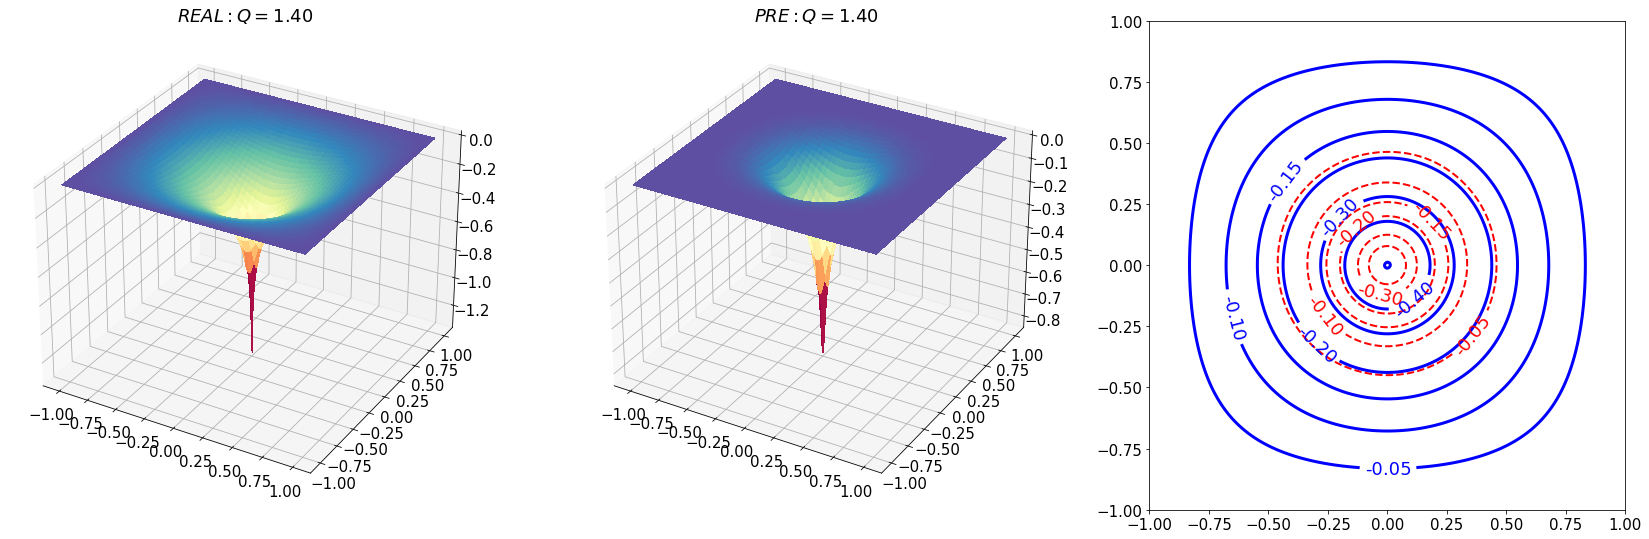

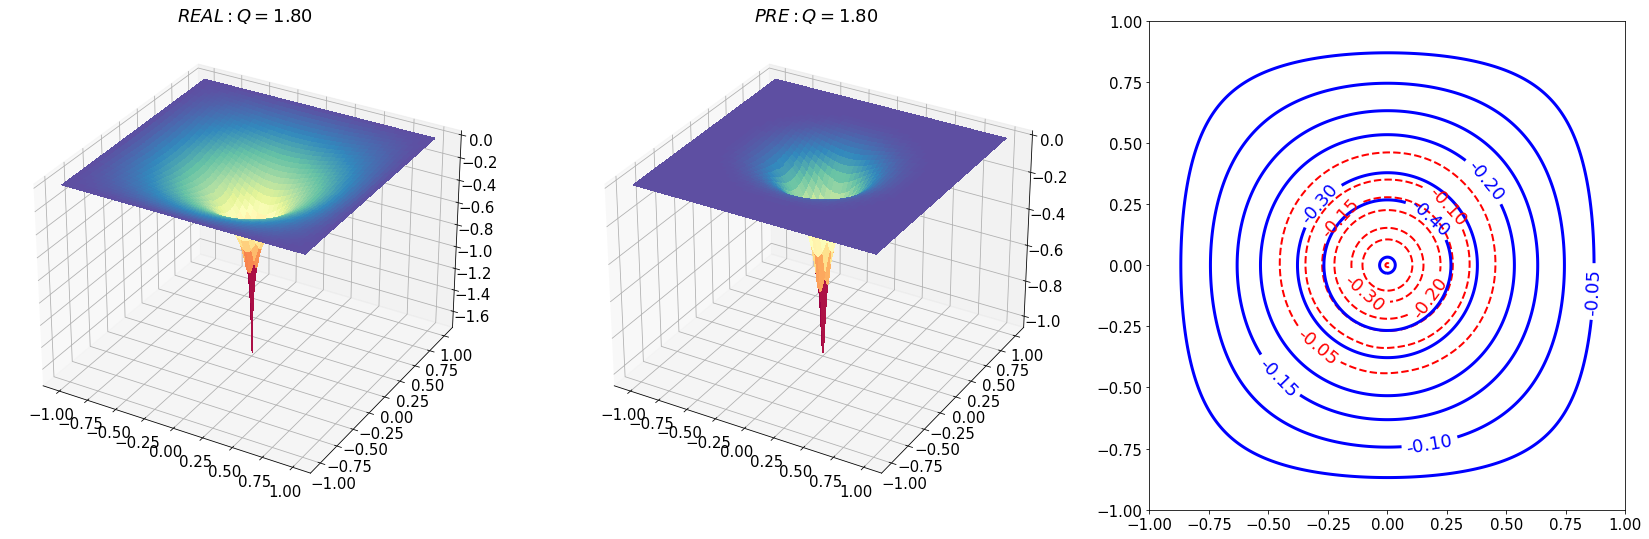

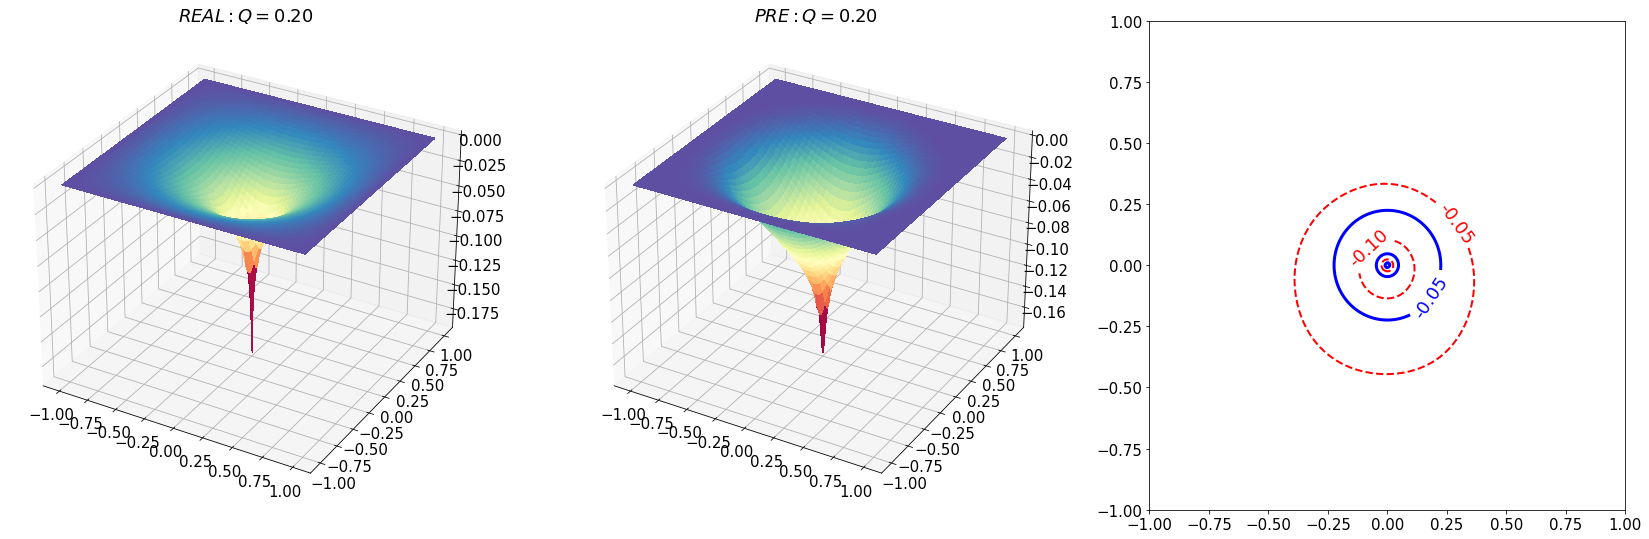

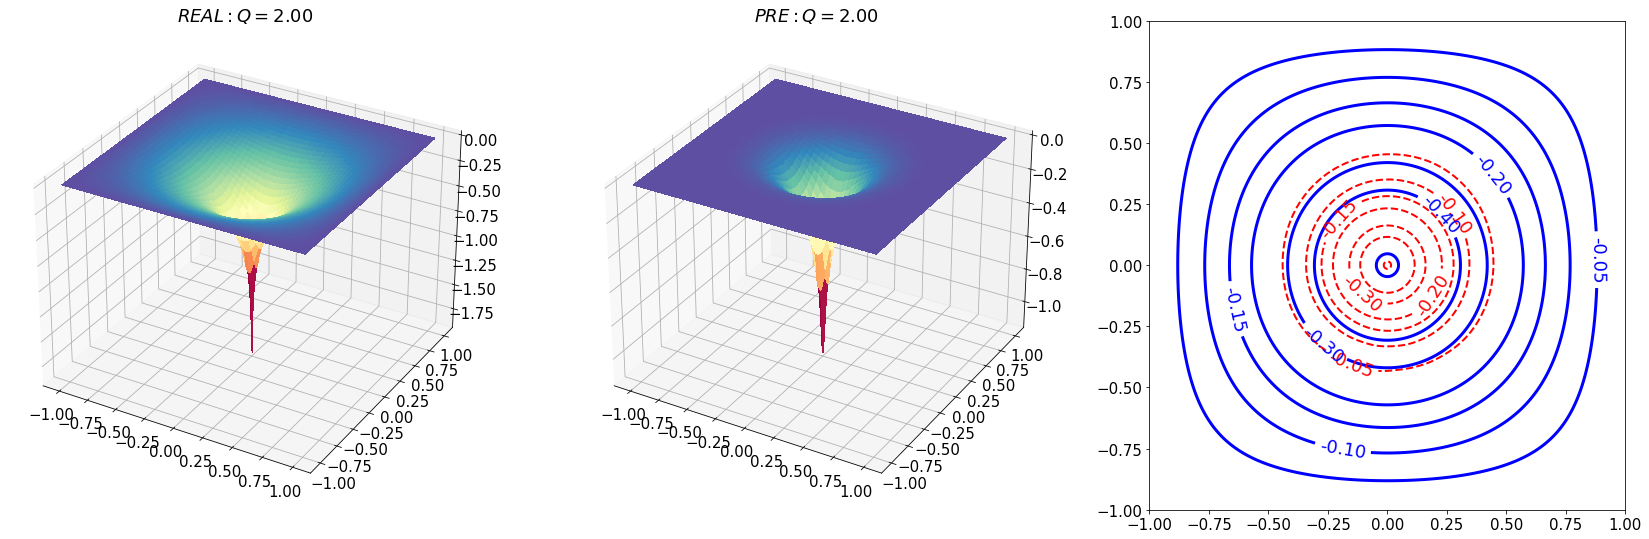

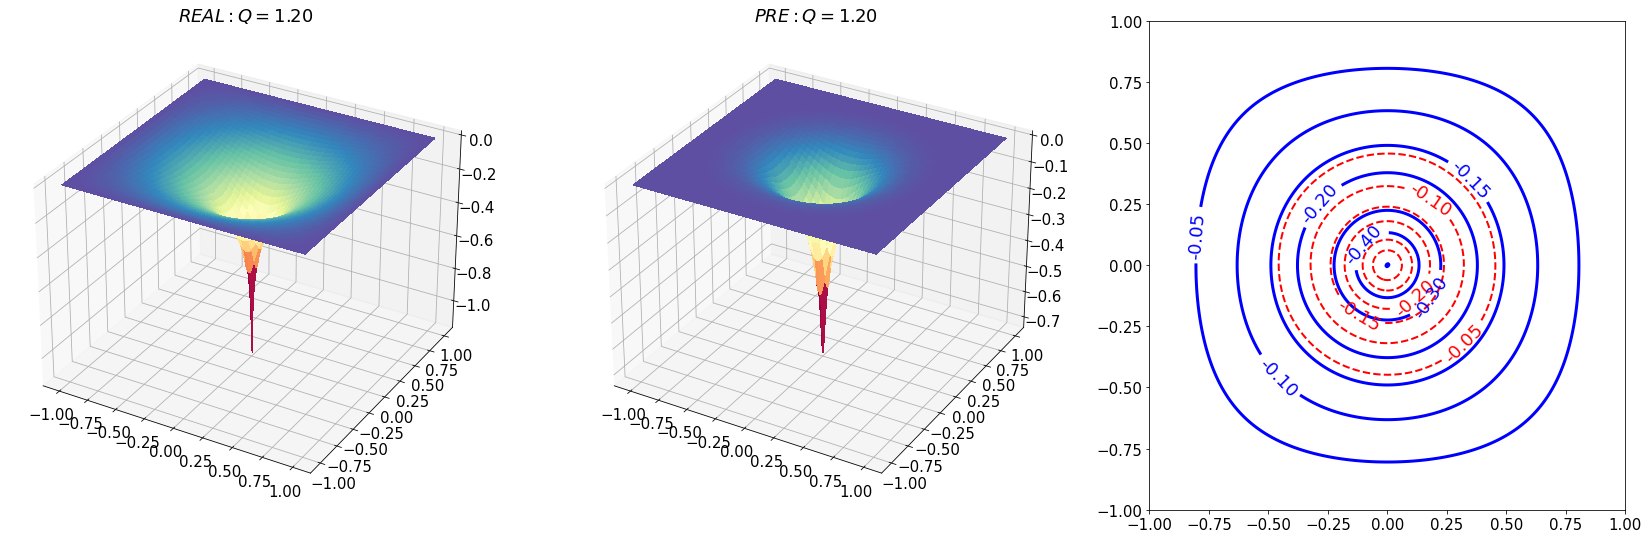

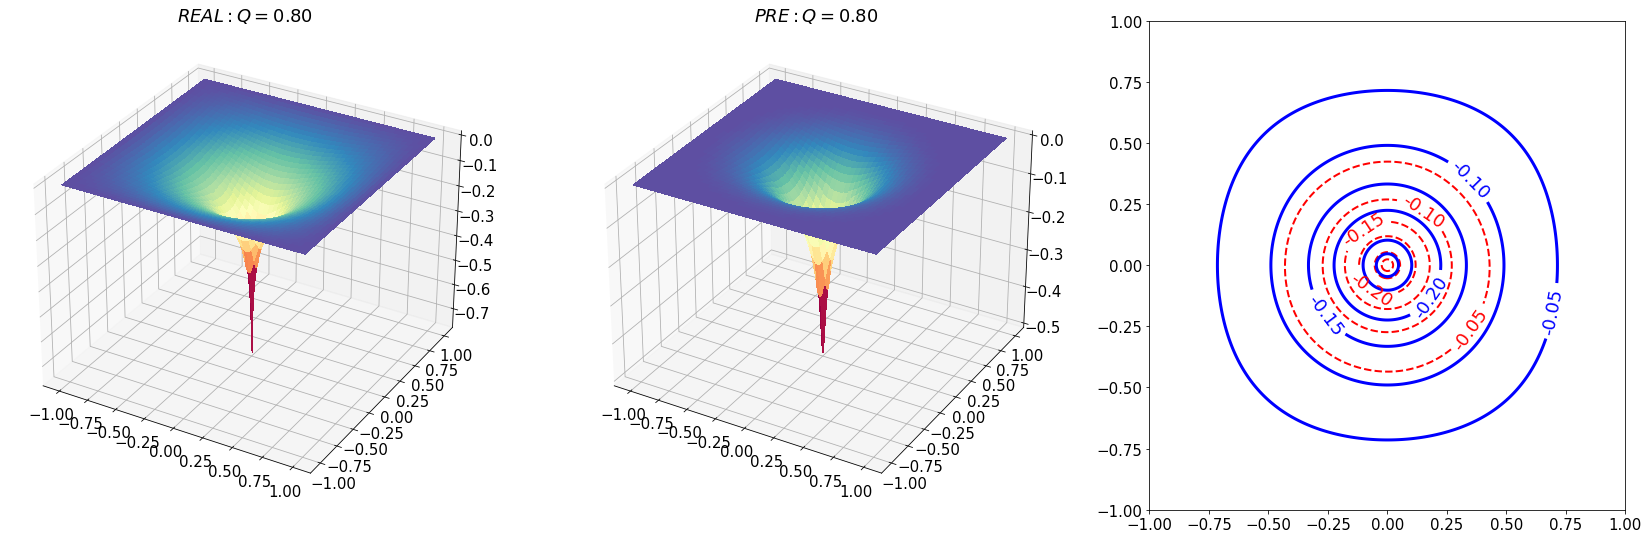

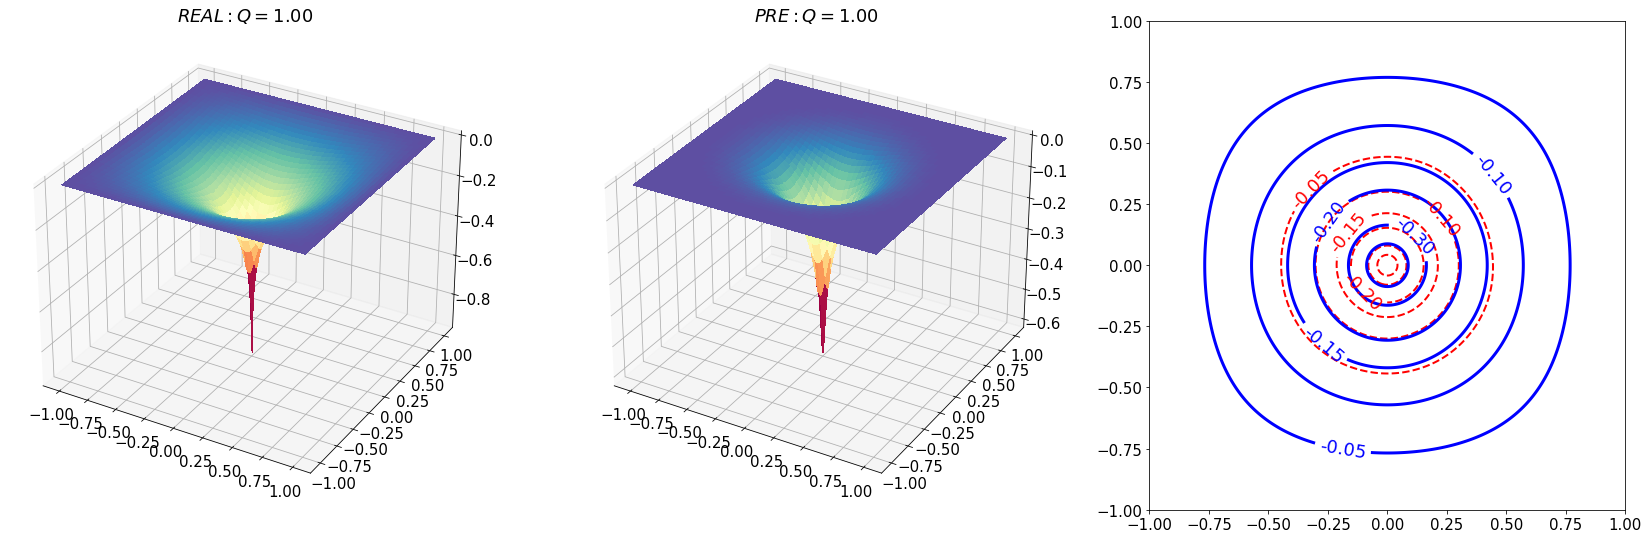

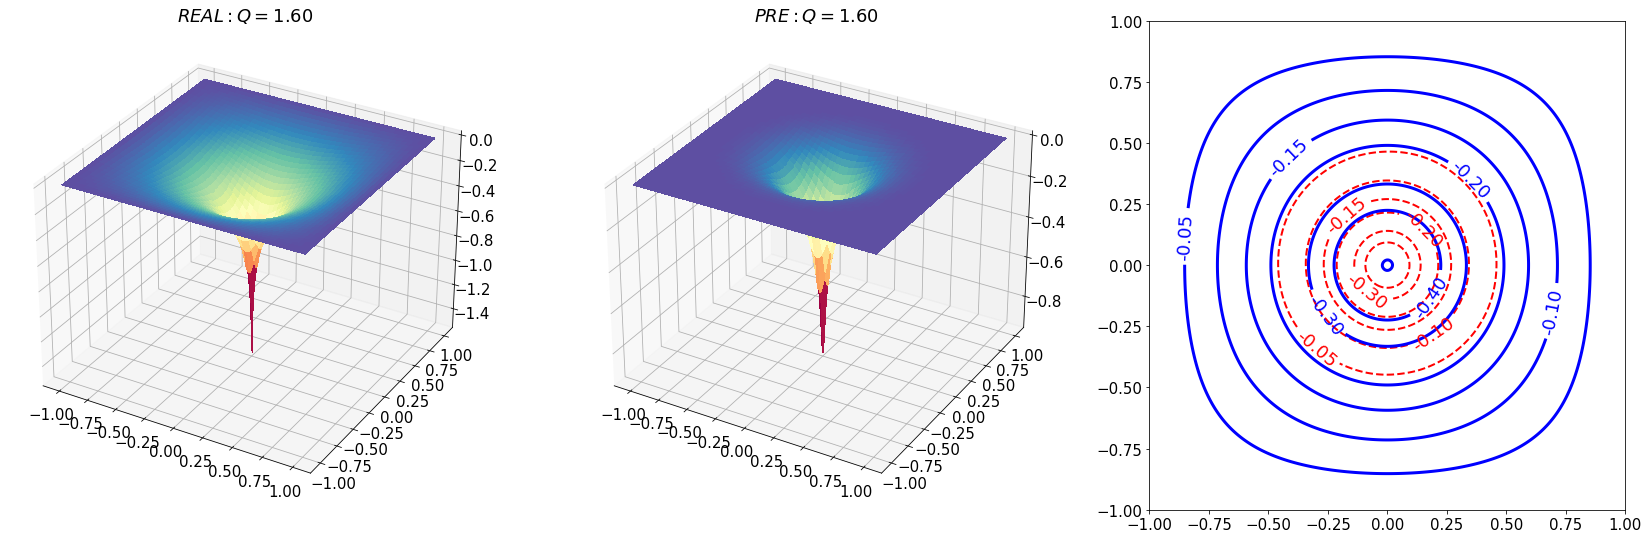

In [25]:
# water_ploter = TestPloter(real_path='./test_data/water_neu/',a=500, h=2.5, k=100, mean=[0,0], sigma=[[1.56,0],[0,1.56]],
#                           model=Hard_FD_Rec_Module, rhs=Dir_RHS_Rec, dv=100,
#                           ckpt = './lightning_logs/water_neu/checkpoints/epoch=47-step=47519.ckpt') 
# water_ploter.fourth_plot(levels=[65, 75, 80, 85, 90, 95, 99])

green_neu_ploter = TestPloter(real_path='./real/green/',a=1, h=0.005, k=1, mean=[0,0], sigma=[[1e-4,0],[0,1e-4]],
                          model=Hard_FD_Rec_Module, rhs=XNeuYDir_RHS_Rec, dv=0, nv=0,
                          ckpt = './lightning_logs/version_0/checkpoints/epoch=27-step=27719.ckpt') 
green_neu_ploter.triple_plot(levels=[-1.0, -0.4, -0.3, -0.2, -0.15, -0.1, -0.05])